# Parallax figure
> Georgios Varnavides*, Stephanie Ribet* et al.  
> 05/20/2024

This notebook reproduces the parallax figure (Fig. 3) in the manuscript [Iterative Phase Retrieval Algorithms for Scanning Transmission Electron Microscopy](https://arxiv.org/abs/2309.05250).

## Imports

In [1]:
import ase 
import abtem
import py4DSTEM
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.ndimage import zoom,gaussian_filter, rotate

import cmasher as cmr

## abTEM Simulations

In [2]:
outer_cnt = ase.build.nanotube(12, 8, length=1)
inner_cnt = ase.build.nanotube(6, 4, length=1)
double_walled_cnt = outer_cnt + inner_cnt
double_walled_cnt.center(vacuum=0, axis=(0,1))
padding = (3*double_walled_cnt.cell[2,2] - double_walled_cnt.cell[0,0])
double_walled_cnt.center(vacuum=padding/2, axis=1)
double_walled_cnt.center(vacuum=10, axis=0)

# double_walled_cnt.rotate('x', 'z', rotate_cell=True)
# manual rotation
positions = double_walled_cnt.positions
positions_new = positions.copy()
positions_new[:,0] = positions[:,2]
positions_new[:,2] = positions[:,0]

double_walled_cnt = ase.Atoms(
    double_walled_cnt.symbols,
    positions = positions_new,
    cell=np.array([
        double_walled_cnt.cell[2,2],
        double_walled_cnt.cell[1,1],
        double_walled_cnt.cell[0,0]
    ])
)
length = double_walled_cnt.cell[0,0]
double_walled_cnt.cell[0,0] += 2*length

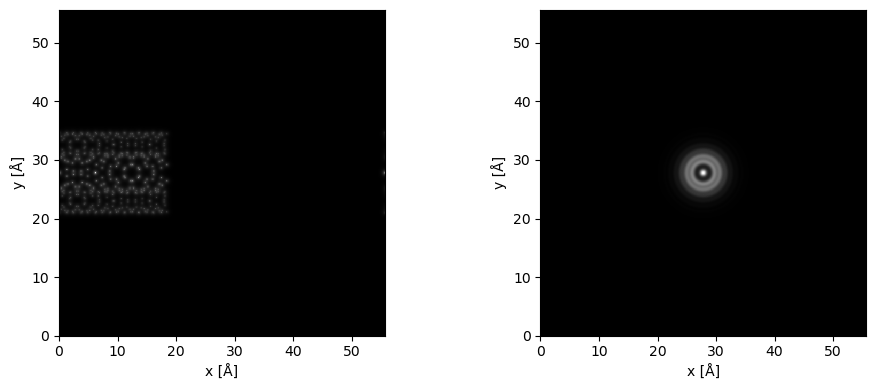

In [3]:
frozen_phonons = abtem.temperature.FrozenPhonons(double_walled_cnt, 12, 0.075)

static_potential = abtem.Potential(
    #frozen_phonons,  # uncomment this for a realistic simulation     
    double_walled_cnt, # comment this for a realistic simulation
    gpts=(int(3*96*3*np.sqrt(2)/2),int(3*96*3*np.sqrt(2)/2)),
    device="gpu",
    projection="infinite",
    parametrization="kirkland",
)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))

static_potential.project().show(ax=ax1)
probe = abtem.Probe(semiangle_cutoff=25, energy=80e3, defocus=200,device="gpu")
probe.match_grid(static_potential)
probe.show(ax=ax2)

fig.tight_layout();

In [4]:
pixelated_detector = abtem.PixelatedDetector(max_angle=None)

grid_scan = abtem.GridScan(
    (0, static_potential.extent[1]/2-static_potential.extent[0]/6), (static_potential.extent[0]/3,static_potential.extent[1]/2+static_potential.extent[0]/6),
    gpts=(37,37),
    endpoint=True
)

measurement = probe.scan(grid_scan, pixelated_detector, static_potential)
sx,sy,qx,qy = measurement.shape
crop_qx = (qx - 96)//2
crop_qy = (qy - 96)//2

array = measurement.array[:,:,crop_qx:crop_qx+96,crop_qy:crop_qy+96]
dc_no_noise = py4DSTEM.DataCube(data = array.copy())
# rotate
array = rotate(array,angle = 17, axes=(-2,-1),order=1,reshape=False)

Potential:   0%|          | 0/68 [00:00<?, ?it/s]

Scan:   0%|          | 0/1369 [00:00<?, ?it/s]

In [5]:
np.random.seed(2024)
electrons_per_area = 1e5
electrons_per_probe = electrons_per_area*np.array(grid_scan.sampling).prod()
noisy_array = np.random.poisson(array*electrons_per_probe).astype(np.uint16)

dc = py4DSTEM.DataCube(noisy_array)
dc.calibration.set_R_pixel_size(measurement.calibrations[0].sampling)
dc.calibration.set_R_pixel_units('A')
dc.calibration.set_Q_pixel_size(measurement.calibrations[2].sampling)
dc.calibration.set_Q_pixel_units('mrad')
dc.calibration

bin_factor = 4
dc_binned = dc.copy()
dc_binned.bin_Q(bin_factor)

DataCube( A 4-dimensional array of shape (37, 37, 24, 24) called 'datacube',
          with dimensions:

              Rx = [0.0,0.515803041652313,1.031606083304626,...] A
              Ry = [0.0,0.515803041652313,1.031606083304626,...] A
              Qx = [0.0,2.998356618538621,5.996713237077242,...] mrad
              Qy = [0.0,2.998356618538621,5.996713237077242,...] mrad
)

## DPC

Best fit rotation forced to -17 degrees.
Transpose of intensities forced to False.
Reconstructing phase: 100%|█| 64/64 [00:00<00:00, 821


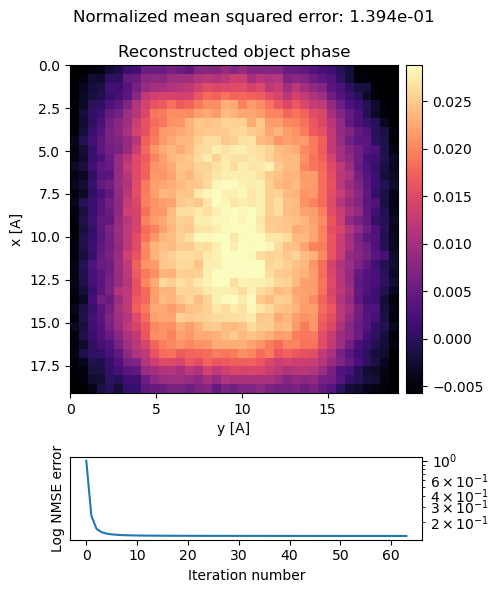

In [6]:
dpc = py4DSTEM.process.phase.DPC(
    dc, 
    energy = 80e3, 
).preprocess(
    force_com_rotation=-17,
    force_com_transpose=False,
    plot_center_of_mass=False,
    fit_function="constant",
).reconstruct(
    q_lowpass=1.5,
).visualize(
)

## Parallax

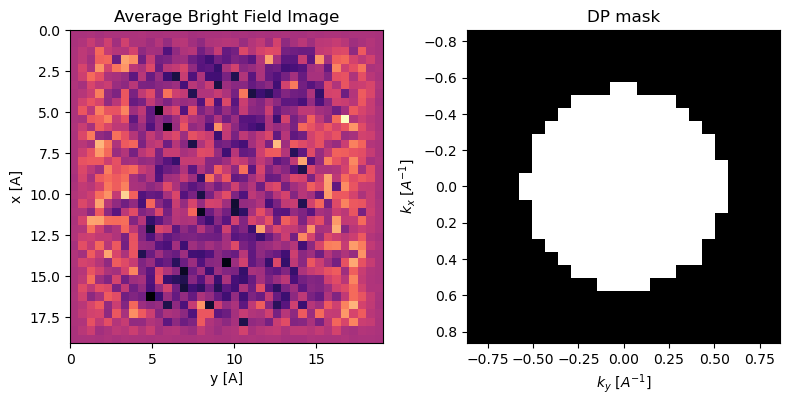

In [7]:
parallax_high_bin = py4DSTEM.process.phase.Parallax(
    datacube = dc_binned, 
    energy = 80e3, 
    verbose= True,
    object_padding_px=(8,8),
).preprocess(
    normalize_images = True,
    edge_blend = 4,
    threshold_intensity = 0.75,
    apply_realspace_mask_to_stack=False,
)

Alignment at bin 8: 100%|█| 4/4 [00:00<00:00, 1209.08
Alignment at bin 4: 100%|█| 18/18 [00:00<00:00, 1842.
Alignment at bin 4: 100%|█| 18/18 [00:00<00:00, 1849.
Alignment at bin 4: 100%|█| 18/18 [00:00<00:00, 1885.
Alignment at bin 4: 100%|█| 18/18 [00:00<00:00, 1870.
Alignment at bin 4: 100%|█| 18/18 [00:00<00:00, 1897.
Alignment at bin 4: 100%|█| 18/18 [00:00<00:00, 1892.
Alignment at bin 4: 100%|█| 18/18 [00:00<00:00, 1893.
Alignment at bin 4: 100%|█| 18/18 [00:00<00:00, 1919.


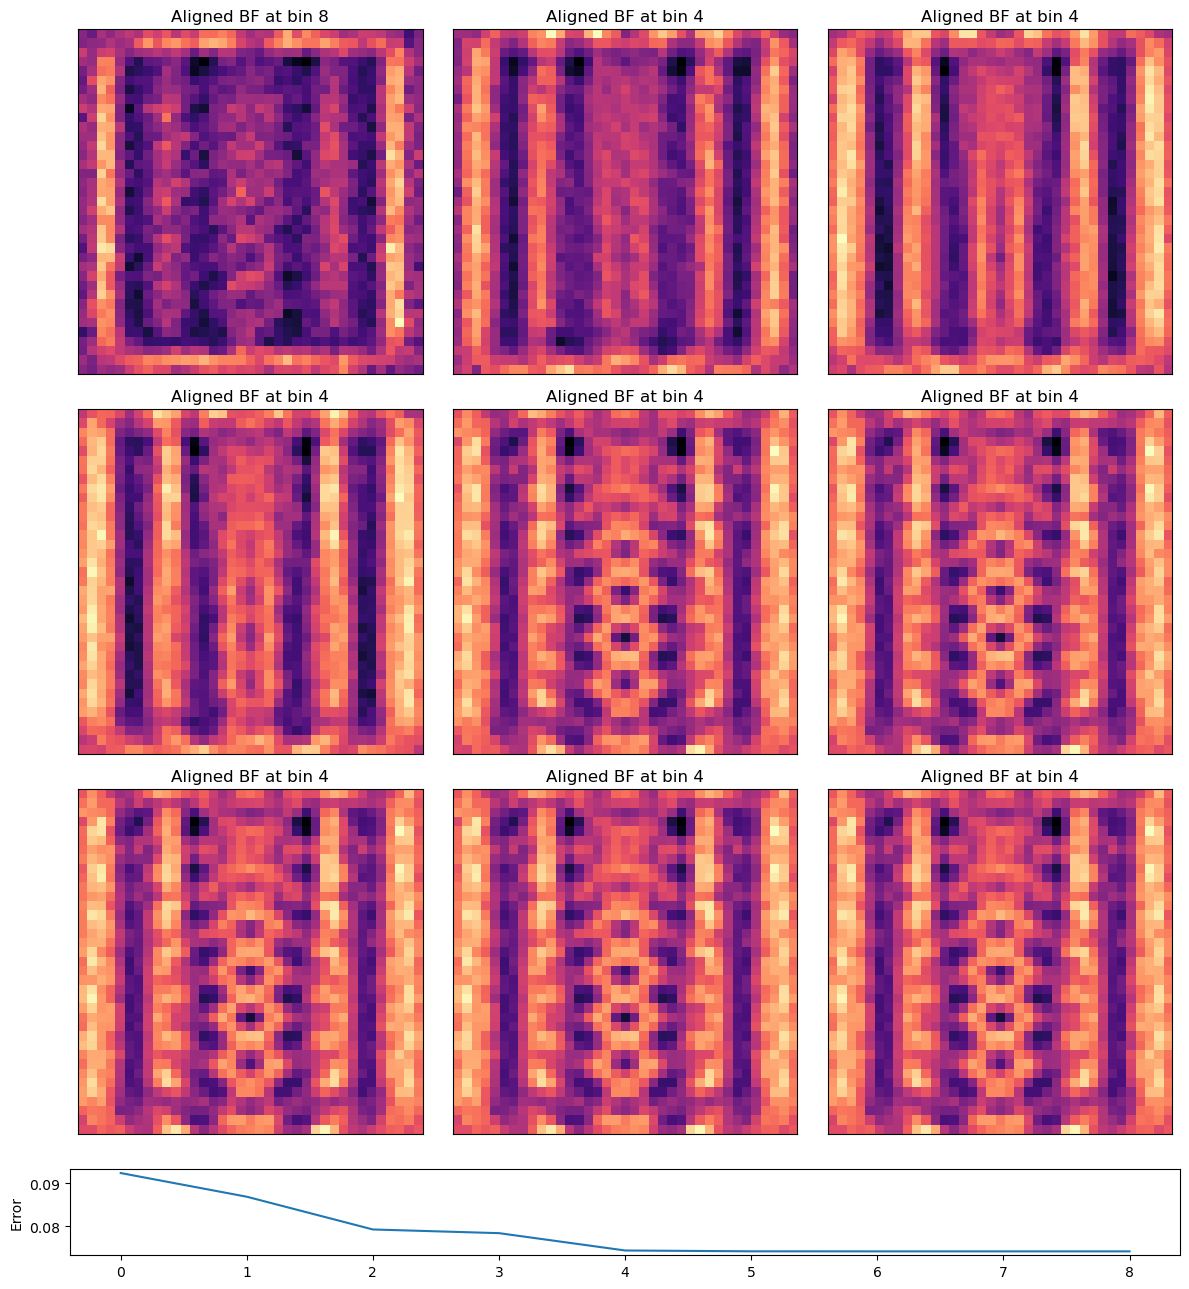

In [8]:
parallax_high_bin = parallax_high_bin.reconstruct(
    min_alignment_bin = 4,
    num_iter_at_min_bin =  8,
    regularize_shifts=False,
    reset = True,
)

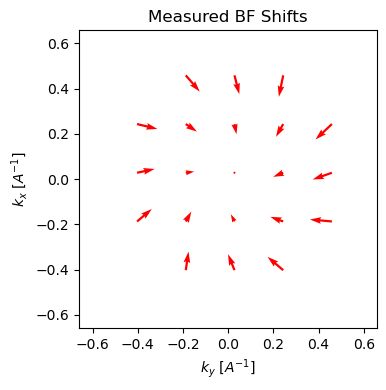

In [9]:
parallax_high_bin.show_shifts(
    scale_arrows=0.2,
    plot_arrow_freq= 3
)

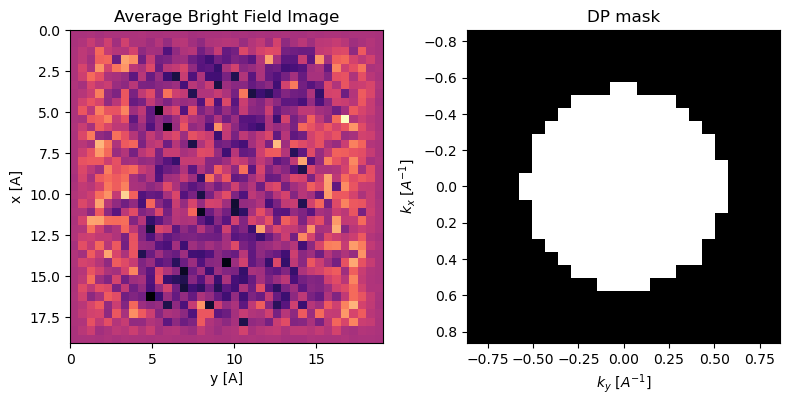

In [10]:
parallax_low_bin = py4DSTEM.process.phase.Parallax(
    datacube = dc_binned, 
    energy = 80e3, 
    verbose= True,
    object_padding_px=(8,8),
).preprocess(
    normalize_images = True,
    edge_blend = 4,
    threshold_intensity = 0.75,
    apply_realspace_mask_to_stack=False,
)

Alignment at bin 8: 100%|█| 4/4 [00:00<00:00, 1448.43
Alignment at bin 4: 100%|█| 18/18 [00:00<00:00, 1878.
Alignment at bin 2: 100%|█| 58/58 [00:00<00:00, 2005.
Alignment at bin 1: 100%|█| 54/54 [00:00<00:00, 2036.
Alignment at bin 1: 100%|█| 54/54 [00:00<00:00, 2022.
Alignment at bin 1: 100%|█| 54/54 [00:00<00:00, 2041.
Alignment at bin 1: 100%|█| 54/54 [00:00<00:00, 2043.
Alignment at bin 1: 100%|█| 54/54 [00:00<00:00, 2042.
Alignment at bin 1: 100%|█| 54/54 [00:00<00:00, 2047.
Alignment at bin 1: 100%|█| 54/54 [00:00<00:00, 2042.
Alignment at bin 1: 100%|█| 54/54 [00:00<00:00, 2058.
Alignment at bin 1: 100%|█| 54/54 [00:00<00:00, 2048.


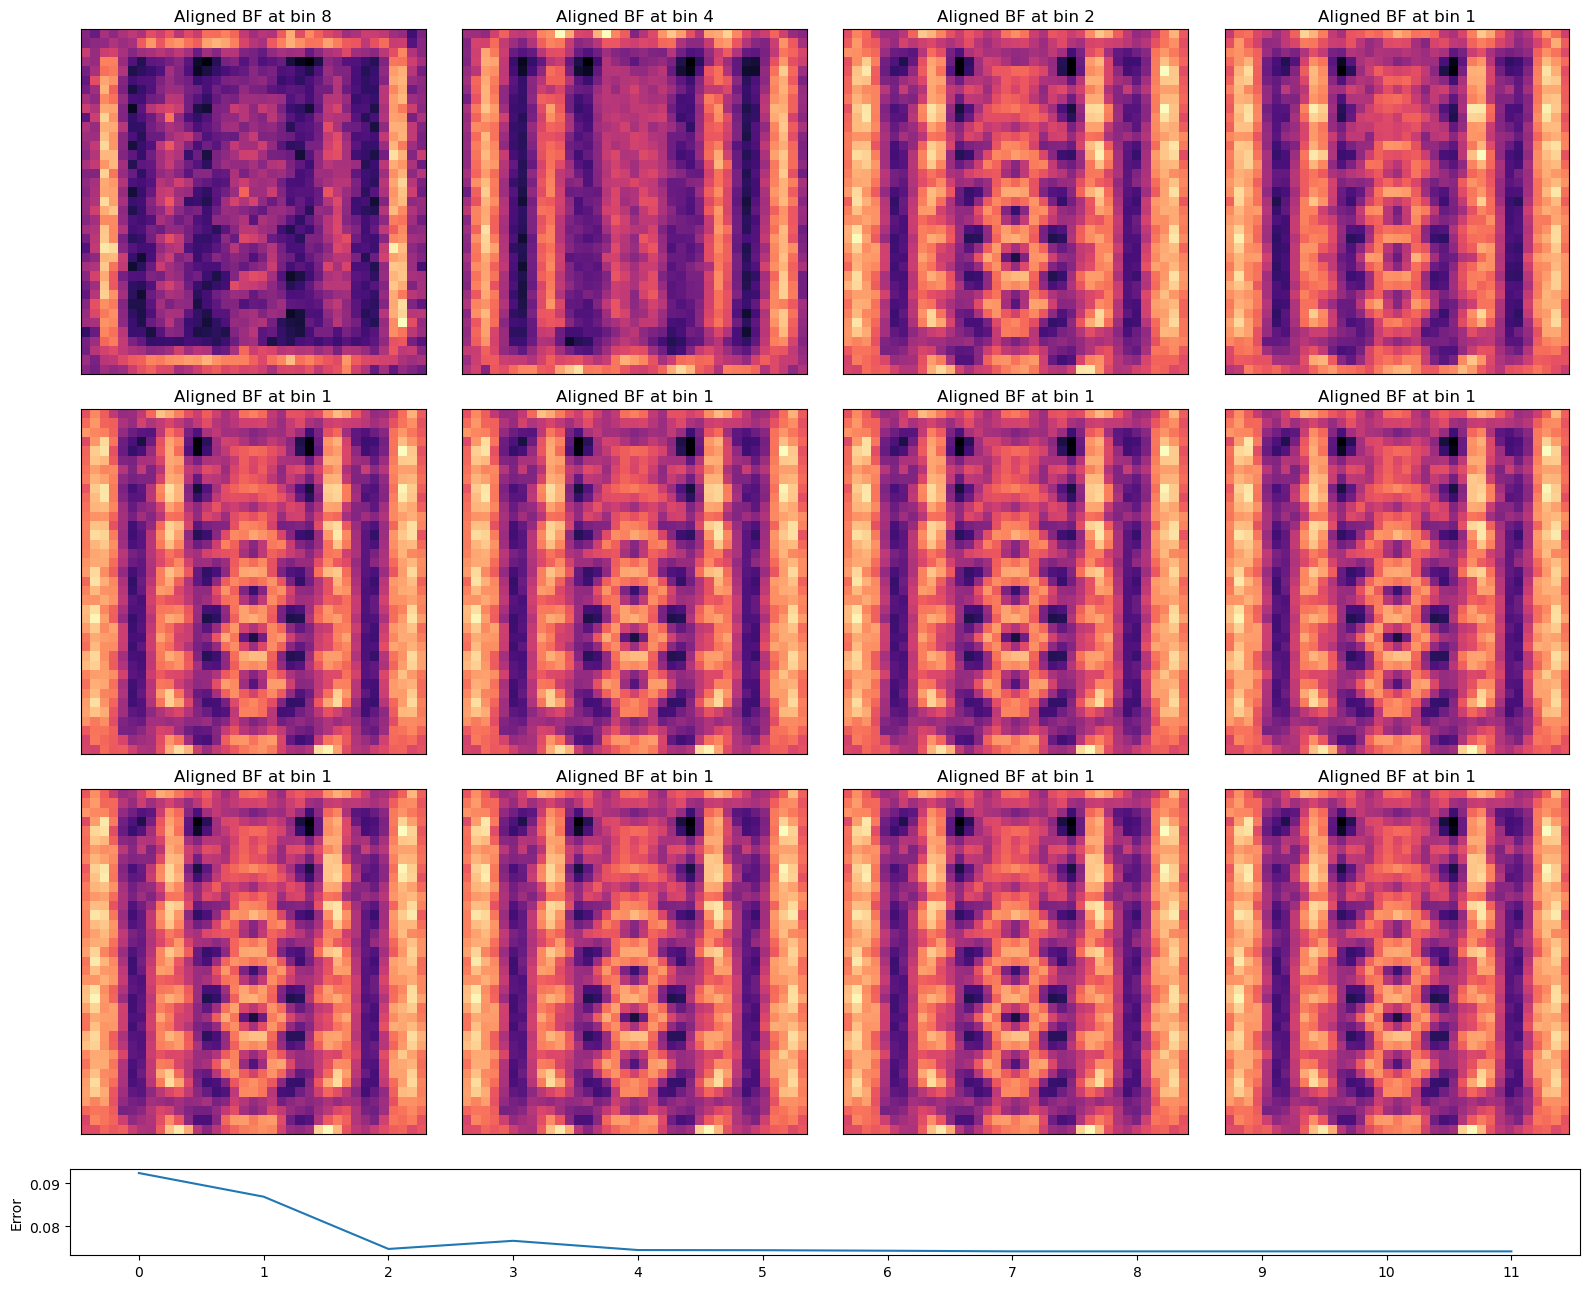

In [11]:
parallax_low_bin = parallax_low_bin.reconstruct(
    min_alignment_bin = 1,
    num_iter_at_min_bin =  9,
    regularize_shifts=False,
    reset = True,
)

Rotation of Q w.r.t. R = -16.955 deg
Astigmatism (A1x,A1y)  = (5,-0) Ang
Aberration C1          =  -166 Ang
Defocus dF             = 166 Ang
Transpose              = False


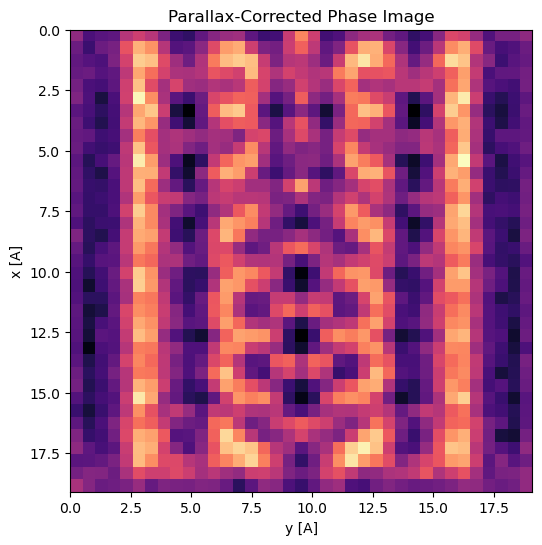

In [12]:
parallax_low_bin = parallax_low_bin.aberration_fit(
).aberration_correct(
)

In [13]:
parallax_unbinned_phase_image = parallax_low_bin.object_cropped.copy()

Dark-field upsampling limit of 0.89 is less than 1, implying a scan step-size smaller than Nyquist. setting to 1.
Requested upsampling factor exceeds dark-field upsampling limit of 1.00.


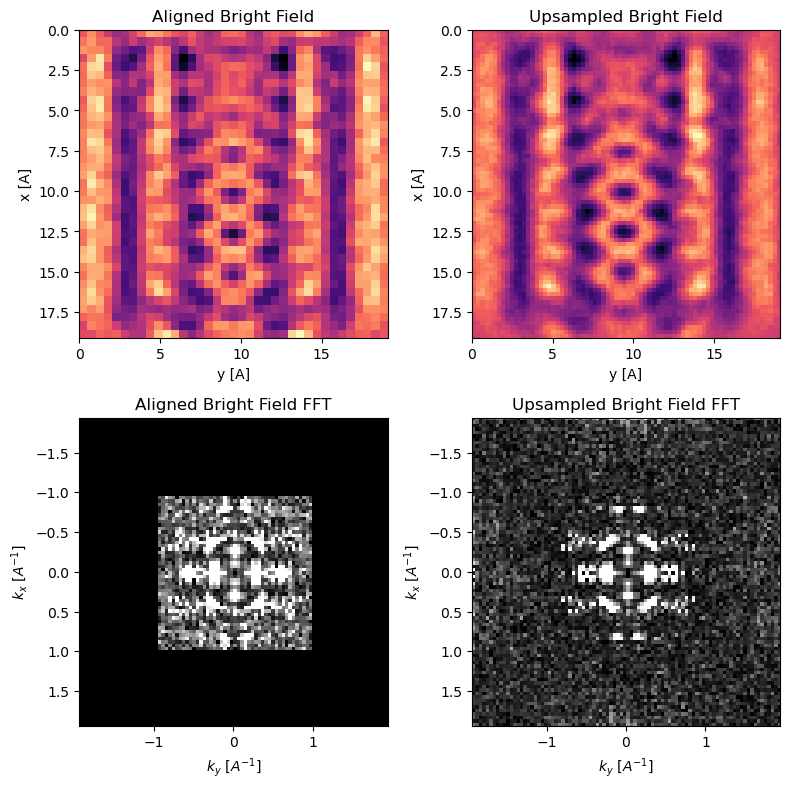

In [14]:
parallax_low_bin = parallax_low_bin.subpixel_alignment(
    plot_upsampled_FFT_comparison=True,
    kde_upsample_factor=2,
)

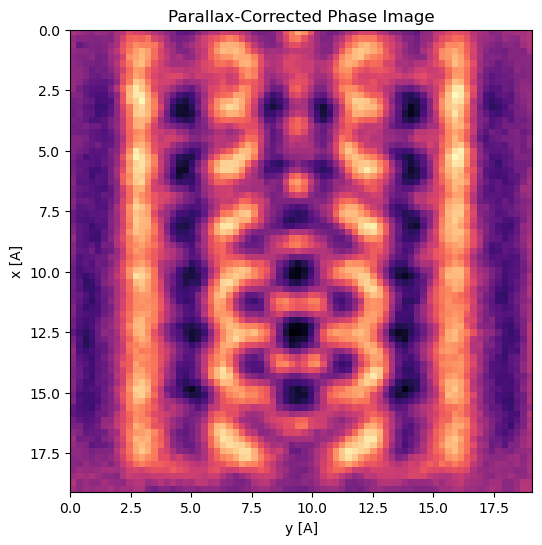

In [15]:
parallax_low_bin = parallax_low_bin.aberration_correct()

## Visualization

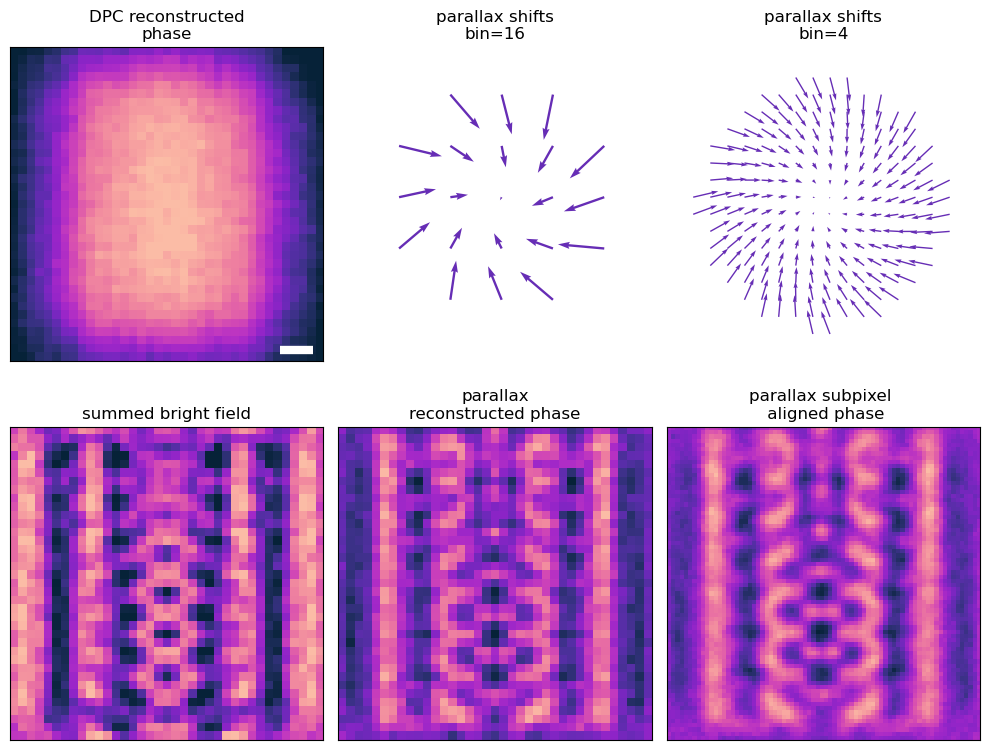

In [16]:
fig, ax = plt.subplots(2,3,figsize = (10,8))

cmap = cmr.bubblegum

py4DSTEM.show(
    dpc.object_phase, 
    figax = (fig, ax[0,0]), 
    ticks = False, 
    title = "DPC reconstructed\nphase", 
    cmap = cmap,
    scalebar ={
        'label' : False,
    }, #2A
    pixelsize= dc.calibration.get_R_pixel_size(),
    pixelunits = "A",
)

scale_arrows=0.4
plot_arrow_freq= 3

dp_mask_ind = np.nonzero(parallax_high_bin._dp_mask)
yy, xx = np.meshgrid(
    np.arange(parallax_high_bin._dp_mask.shape[1]), np.arange(parallax_high_bin._dp_mask.shape[0])
)
freq_mask = np.logical_and(xx % plot_arrow_freq == 0, yy % plot_arrow_freq == 0)
masked_ind = np.logical_and(freq_mask, parallax_high_bin._dp_mask)
plot_ind = masked_ind[dp_mask_ind]

ax[0,1].quiver(
    parallax_high_bin._kxy[plot_ind, 1],
    parallax_high_bin._kxy[plot_ind, 0],
    parallax_high_bin._xy_shifts[plot_ind, 1]
    * scale_arrows
    * parallax_high_bin._reciprocal_sampling[0]
    ,
    parallax_high_bin._xy_shifts[plot_ind, 0]
    * scale_arrows
    * parallax_high_bin._reciprocal_sampling[1]
    ,
    color='#662DB5',
    angles="xy",
    scale_units="xy",
    scale=1,
)

kr_max = np.max(parallax_high_bin._kr)
ax[0,1].set_xlim([-1.2 * kr_max, 1.2 * kr_max])
ax[0,1].set_ylim([-1.2 * kr_max, 1.2 * kr_max])
ax[0,1].set_aspect('equal')
ax[0,1].axis('off')
ax[0,1].set_title('parallax shifts\nbin=16')


scale_arrows=0.2
plot_arrow_freq= 1

dp_mask_ind = np.nonzero(parallax_low_bin._dp_mask)
yy, xx = np.meshgrid(
    np.arange(parallax_low_bin._dp_mask.shape[1]), np.arange(parallax_low_bin._dp_mask.shape[0])
)
freq_mask = np.logical_and(xx % plot_arrow_freq == 0, yy % plot_arrow_freq == 0)
masked_ind = np.logical_and(freq_mask, parallax_low_bin._dp_mask)
plot_ind = masked_ind[dp_mask_ind]

ax[0,2].quiver(
    parallax_low_bin._kxy[plot_ind, 1],
    parallax_low_bin._kxy[plot_ind, 0],
    parallax_low_bin._xy_shifts[plot_ind, 1]
    * scale_arrows
    * parallax_low_bin._reciprocal_sampling[0]
    ,
    parallax_low_bin._xy_shifts[plot_ind, 0]
    * scale_arrows
    * parallax_low_bin._reciprocal_sampling[1]
    ,
    color='#662DB5',
    angles="xy",
    scale_units="xy",
    scale=1,
)

kr_max = np.max(parallax_low_bin._kr)
ax[0,2].set_xlim([-1.2 * kr_max, 1.2 * kr_max])
ax[0,2].set_ylim([-1.2 * kr_max, 1.2 * kr_max])
ax[0,2].set_aspect('equal')
ax[0,2].axis('off')
ax[0,2].set_title('parallax shifts\nbin=4')


p = parallax_low_bin._object_padding_px[0]//2
py4DSTEM.show(
    parallax_low_bin.recon_BF[p:-p,p:-p], 
    figax = (fig, ax[1,0]), 
    ticks = False, 
    title = "summed bright field", 
    cmap = cmap
)


py4DSTEM.show(
    parallax_unbinned_phase_image, 
    figax = (fig, ax[1,1]), 
    ticks = False, 
    title = "parallax\nreconstructed phase", 
    cmap = cmap,
    vmax = 1,
    vmin = 0
)


py4DSTEM.show(
    parallax_low_bin.object_cropped, 
    figax = (fig, ax[1,2]), 
    ticks = False, 
    title = "parallax subpixel \n aligned phase", 
    cmap = cmap,
    vmax = 1,
    vmin = 0
)

plt.tight_layout()
# plt.savefig('parallax.svg', dpi = 350, bbox_inches = "tight", pad_inches = 0.1)

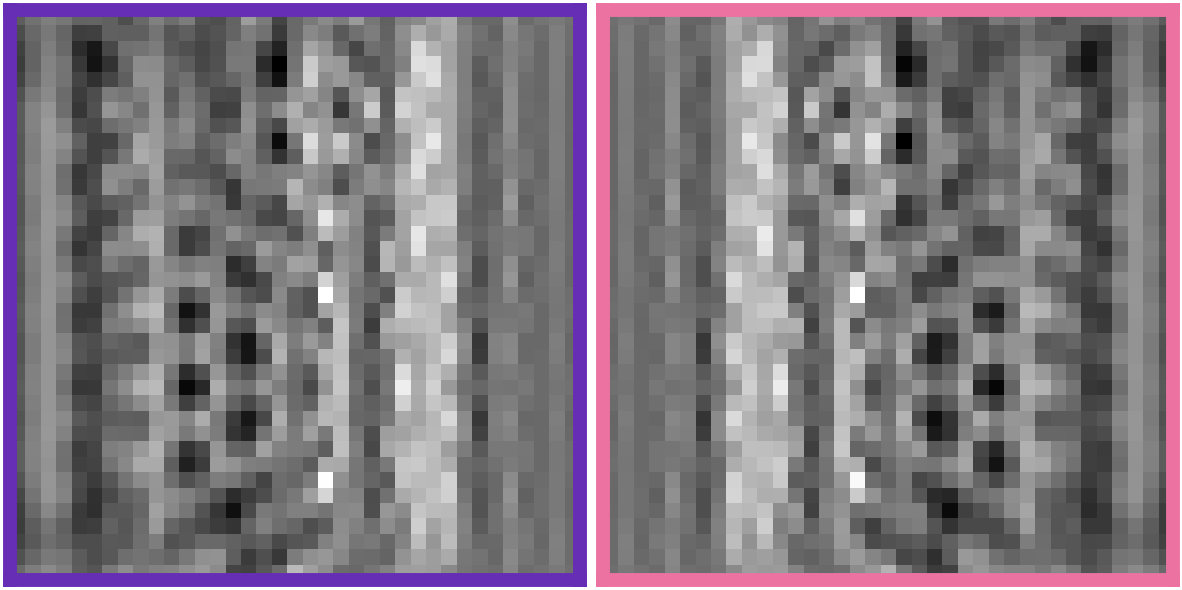

In [17]:
pixel_size = 3
left_no_noise = np.mean(dc_no_noise[:,:,48-pixel_size:48+pixel_size,17:21], axis = (2,3))

right_no_noise = np.mean(dc_no_noise[:,:,48-pixel_size:48+pixel_size,76:80], axis = (2,3))

# fig, ax = plt.subplots(1,2, figsize = (4,12))
fig, ax = py4DSTEM.visualize.show_image_grid(
    get_ar = lambda i :[
        left_no_noise,
        right_no_noise
    ][i], 
    H = 1,
    W = 2,
    cmap = "gray", 
    ticks= False,
    get_bordercolor= lambda i:['#662DB5','#EB72A1'][i],
    borderwidth=10,
    returnfig = True,
    vmax = 1,
    vmin = 0,
    # figax = (fig, ax)
)

#plt.savefig('left_right.svg', dpi = 350)


## Postprocessing
> Done in Inkscape